## Instructions
Some questions to consider when working on Tasks 4 & 5:

1. Given a cuisine and a set of candidate dish names of the cuisine, how do we quantify the popularity of a dish? How can we discover the popular dishes that are liked by many reviewers? What kind of dishes should be ranked higher in general if we are to recommend dishes of a cuisine for people to try? Would the number of times a dish is mentioned in all the reviews be a better indicator of a popular dish than the number of restaurants whose reviews mentioned the dish?
2. For people who are interested in a particular dish or a certain type of dishes, which restaurants should be recommended? How can we design a ranking function based on the reviews of the restaurants that mention the particular dish(es)? Should a restaurant with more dish name occurrences be ranked higher than one with more unique dish names?
3. How can you visualize the recommended dishes for a cuisine and the recommended restaurants for particular dishes to make them as useful as possible to users? How can the visualization be incorporated into a usable system? For example, you can imagine using the algorithms you developed for Tasks 4 and 5 to construct a system that allows a user to select a cuisine to see the favorite/popular dishes of the cuisine and further recommends the best restaurants if a user selects a particular dish or a set of dishes that are interesting to him/her.

In [504]:
import pandas as pd
import json
import string
import unicodedata
import re
import itertools
import nltk

from collections import Counter
from collections import OrderedDict 
from tqdm import tqdm
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

In [367]:
path2files="../data/yelp_dataset_challenge_academic_dataset/"
path2buisness=path2files+"yelp_academic_dataset_business.json"
path2reviews=path2files+"yelp_academic_dataset_review.json"
path2dishname="student_dn_annotations.txt"

# from task 3 - quality Indian Dish names
path2qualityindian='../task3/IndianDish_quality.txt'
path2indiandish='../task3/Indian_corrected.label'

In [368]:
# find all the Indian restaurants
business_id = []
restaurant_name = dict()
cuisine = 'Indian'

with open (path2buisness, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        business_json = json.loads(line)
        
        if cuisine in business_json['categories']:
            data_id = business_json['business_id']
            business_id.append(data_id)
            restaurant_name[data_id] = business_json['name']

In [369]:
%%time
# extract the reviews
reviews = [] 
stars = []
rest_name = []

with open (path2reviews, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        review_json = json.loads(line)
        if review_json['business_id'] in business_id:
            reviews.append(review_json['text'])
            stars.append(review_json['stars'])
            rest_name.append(restaurant_name[review_json['business_id']])
print(len(reviews), len(stars), len(rest_name))

8230 8230 8230
CPU times: user 11.3 s, sys: 1.16 s, total: 12.4 s
Wall time: 12.8 s


In [370]:
dish_list = []
with open(path2indiandish, 'r') as rf:
    for line in rf:
        #split_list = line.strip().split()
        if line.strip().split("\t")[1] == "1":
            dish_list.append(line.strip().split("\t")[0])
        
print(len(dish_list))
dish_list

# # extract the "quality" Indian dishes from task 3
# dish_list = []
# with open(path2qualityindian, 'r') as f:
#     for line in f:
#         dish_list.append(unicodedata.normalize('NFKD', line).lower().strip())
        
# print(len(dish_list))
# dish_list[:20]

23


['chick peas',
 'chicken tikka',
 'flat bread',
 'tandoori chicken',
 'rogan josh',
 'mother india',
 'gulab jamun',
 'basmati rice',
 'rice pudding',
 'hot sauce',
 'fried rice',
 'ice cream',
 'south india',
 'tomato soup',
 'indian cuisine',
 'chicken tikka masala',
 'tomato sauce',
 'india gate',
 'the indian sampler',
 'dipping sauce',
 'the naan was',
 'tikka masala',
 'coconut chicken']

## Task 4: Mining Popular Dishes

In this task, you will create a visualization showing a ranking of the dishes for a Yelp cuisine of your choice. You may use the dish list we have provided, the list based on your annotations from Task 3 (or a subset of that list), or any other list for other cuisines. You might find it more interesting to work on a cuisine for which you can recognize many dishes than one with only a few dish names that you recognize.

There are many ways to approach this task; the main challenge will be how to create the ranking. You can devise your own method or use other methods you have learned in the Text Retrieval MOOC. The simplest approach can be to simply count how many times a dish is mentioned in all the reviews of restaurants of a particular cuisine, but you are encouraged to explore how to improve over this simple approach, e.g., by considering ratings of reviews or even sentiment of specific sentences that mention a dish. Even if you just try this simple approach, you may still need to consider options of counting dish mentions based on the number of reviews vs. the number of restaurants, so keep this question in mind: What do you think is the best way of ranking dishes for a cuisine? This is an open research question, but your exploration may help us better understand it.

The following is a sample visualization created using d3.js. You are encouraged to explore other visualization strategies. For example, an interesting visualization could show which dish names occur in what context – that is, they go beyond just the dish names.

![](img/overview1.png)

*Visualization of common phrases and the number of restaurants the phrase appeared in Indian cuisines, with a sentiment analysis included.*

### 4A. Popularity By Dish Mention Count
"The simplest approach can be to simply count how many times a dish is mentioned in all the reviews of restaurants of a particular cuisine"

In [372]:
dish_counter = dict(zip(dish_list, [0]*len(dish_list)))
for dish in dish_list:
    for review in reviews:
        review = review.replace("\t", " ")\
                      .replace("\n", "")\
                      .replace("\r", "")\
                      .lower().strip()
        dish_counter[dish] += review.count(dish)

In [373]:
N = 25
sorted_dish_counter = {k: v for k, v in sorted(dish_counter.items(), key=lambda item: item[1], reverse=True)}
topN = dict(itertools.islice(sorted_dish_counter.items(), N))
dish_count_df = pd.DataFrame(topN.items(), columns=["Dish_Name", "Count"])

In [374]:
topN

{'tikka masala': 1107,
 'chicken tikka': 1054,
 'chicken tikka masala': 787,
 'tandoori chicken': 527,
 'indian cuisine': 364,
 'basmati rice': 249,
 'south india': 247,
 'the naan was': 236,
 'rice pudding': 189,
 'gulab jamun': 155,
 'ice cream': 97,
 'rogan josh': 77,
 'dipping sauce': 51,
 'hot sauce': 38,
 'tomato soup': 35,
 'fried rice': 34,
 'india gate': 34,
 'chick peas': 31,
 'flat bread': 30,
 'mother india': 27,
 'tomato sauce': 27,
 'coconut chicken': 14,
 'the indian sampler': 13}

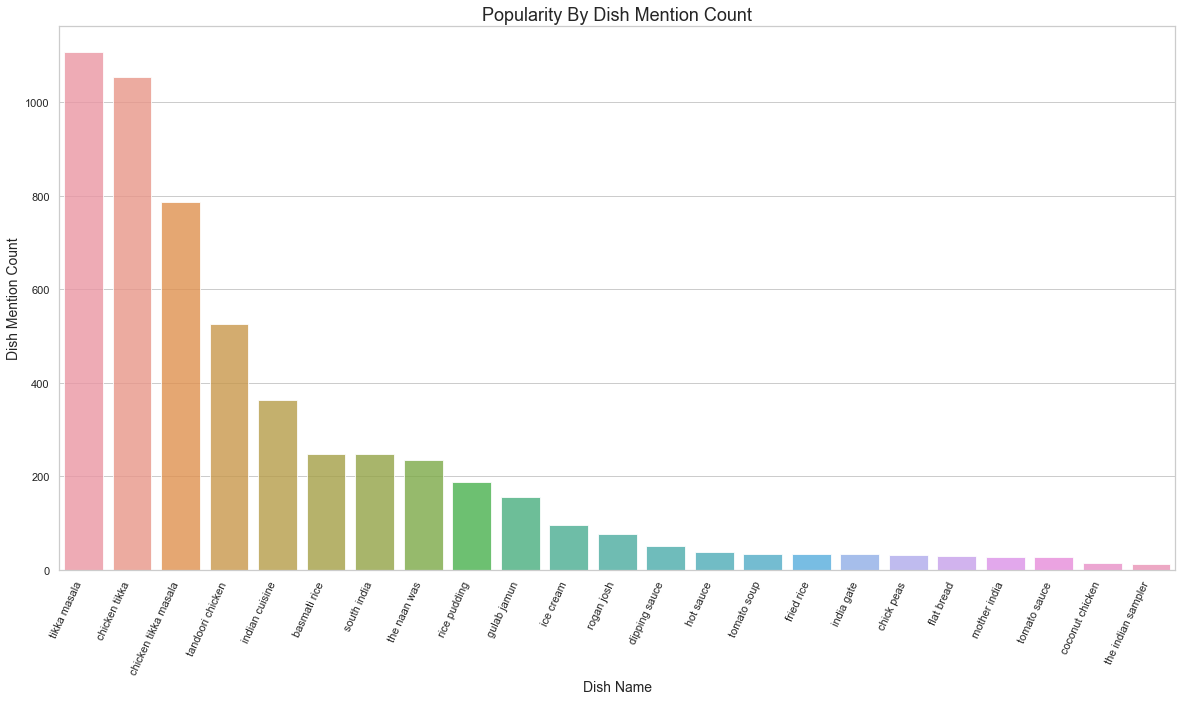

In [375]:
plt.figure(figsize=(20,10))
sns.barplot(x="Dish_Name", y="Count", data=dish_count_df, alpha=0.8)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Popularity By Dish Mention Count', fontsize=18)
plt.xlabel('Dish Name', fontsize=14)
plt.ylabel('Dish Mention Count', fontsize=14)
plt.show()

### 4B. Popularity by Number of Retaurants
Here, we count total number of restaurants whose reviews mentioned a particular dish. This may help us avoid overly weighting certain reviews that may repeatedly mention a dish name.

*Here, we count total number of reviews a dish occcurs in instead of counting the total number of times a dish is mentioned. This may help us avoid overly weighting certain reviews that may repeatedly mention a dish name.*


In [435]:
unique_restaurants = list(set(rest_name))
dish_rest_counter = dict(zip(dish_list, [0]*len(dish_list)))

for dish in dish_list:
    # for each dish, keep track of the unique restaurants that mention the particular dish
    restaurant_tracker = dict(zip(unique_restaurants, [0]*len(unique_restaurants)))
    for i, review in enumerate(reviews):
        review = review.replace("\t", " ")\
                      .replace("\n", "")\
                      .replace("\r", "")\
                      .lower().strip()

        if dish in review:
            restaurant_tracker[rest_name[i]] = 1
    dish_rest_counter[dish] += sum(restaurant_tracker.values())

In [436]:
# dish_rest_counter = dict(zip(dish_list, [0]*len(dish_list)))

# for dish in dish_list:
#     for review in reviews:
#         review = review.replace("\t", " ")\
#                       .replace("\n", "")\
#                       .replace("\r", "")\
#                       .lower().strip()
#         add = 0
#         if dish in review:
#             add = 1
#         dish_rest_counter[dish] += add

In [437]:
N = 25
sorted_dish_counter = {k: v for k, v in sorted(dish_rest_counter.items(), key=lambda item: item[1], reverse=True)}
topN = dict(itertools.islice(sorted_dish_counter.items(), N))
dish_count_df = pd.DataFrame(topN.items(), columns=["Dish_Name", "Count"])

In [438]:
topN

{'chicken tikka': 112,
 'tikka masala': 106,
 'chicken tikka masala': 101,
 'indian cuisine': 99,
 'tandoori chicken': 84,
 'the naan was': 71,
 'basmati rice': 64,
 'gulab jamun': 57,
 'rice pudding': 51,
 'south india': 47,
 'ice cream': 44,
 'rogan josh': 33,
 'dipping sauce': 29,
 'hot sauce': 24,
 'chick peas': 20,
 'tomato sauce': 18,
 'fried rice': 17,
 'flat bread': 16,
 'tomato soup': 15,
 'coconut chicken': 9,
 'india gate': 8,
 'mother india': 6,
 'the indian sampler': 1}

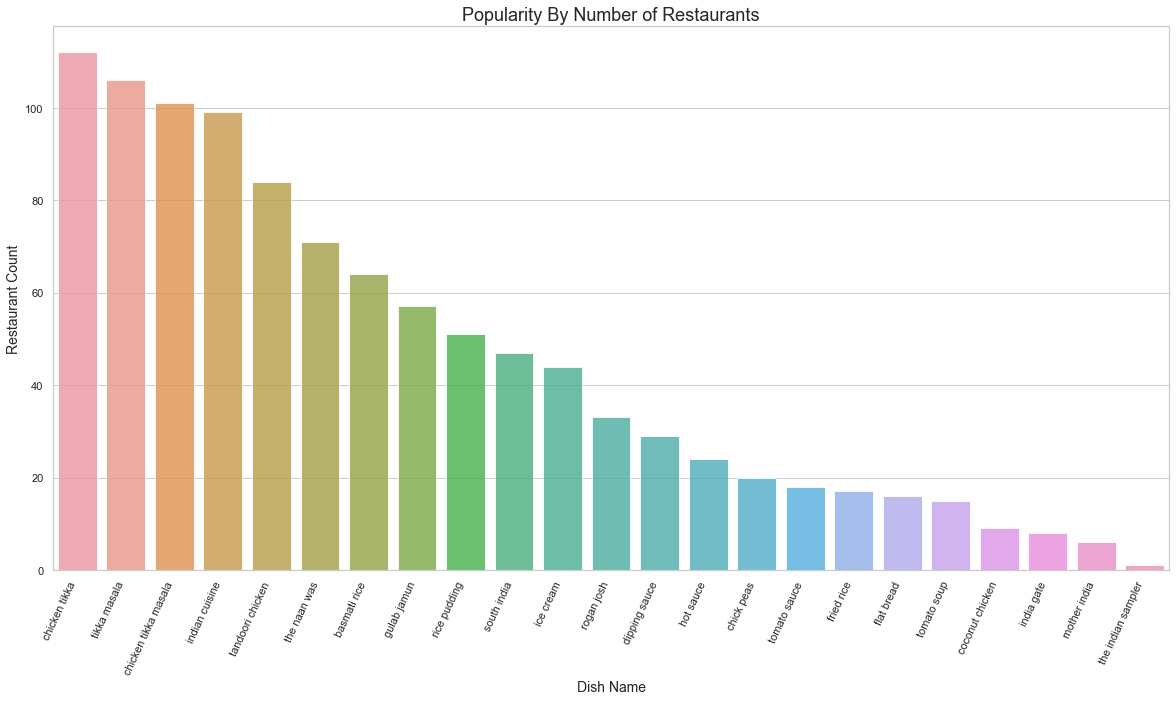

In [440]:
plt.figure(figsize=(20,10))
sns.barplot(x="Dish_Name", y="Count", data=dish_count_df, alpha=0.8)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Popularity By Number of Restaurants', fontsize=18)
plt.xlabel('Dish Name', fontsize=14)
plt.ylabel('Restaurant Count', fontsize=14)
plt.show()

### 4C. Popularity By Average Rating


In [459]:
# initialize dataframe
dish_rating_df = pd.DataFrame(columns=['Dish_Name', 'Total_Rating', "Review_Count"])
dish_rating_df['Dish_Name'] = dish_list
dish_rating_df['Total_Rating'] = [0]*len(dish_list)
dish_rating_df['Review_Count'] = [0]*len(dish_list)

for i, dish in enumerate(dish_list):
    for j, review in enumerate(reviews):
        if stars[j] == 3: # skip "neutral" reviews by stars
            continue
        review = review.replace("\t", " ")\
                      .replace("\n", "")\
                      .replace("\r", "")\
                      .lower().strip()
        if dish in review:
            dish_rating_df.loc[i, 'Review_Count'] += 1 # used for average
            dish_rating_df.loc[i, 'Total_Rating'] += stars[j]

# compute average rating
dish_rating_df['Average_Rating'] = dish_rating_df['Total_Rating'] / dish_rating_df['Review_Count']

In [460]:
# Use # of reviews as tiebreaker if needed
dish_rating_df = dish_rating_df.sort_values(by=['Average_Rating', 'Review_Count'], axis=0, ascending=False)

In [461]:
dish_rating_df

,Dish_Name,Total_Rating,Review_Count,Average_Rating
19,dipping sauce,176,40,4.400000
11,ice cream,306,71,4.309859
18,the indian sampler,43,10,4.300000
4,rogan josh,266,63,4.222222
8,rice pudding,580,138,4.202899
2,flat bread,113,27,4.185185
12,south india,669,162,4.129630
0,chick peas,99,24,4.125000
14,indian cuisine,1137,278,4.089928
22,coconut chicken,53,13,4.076923


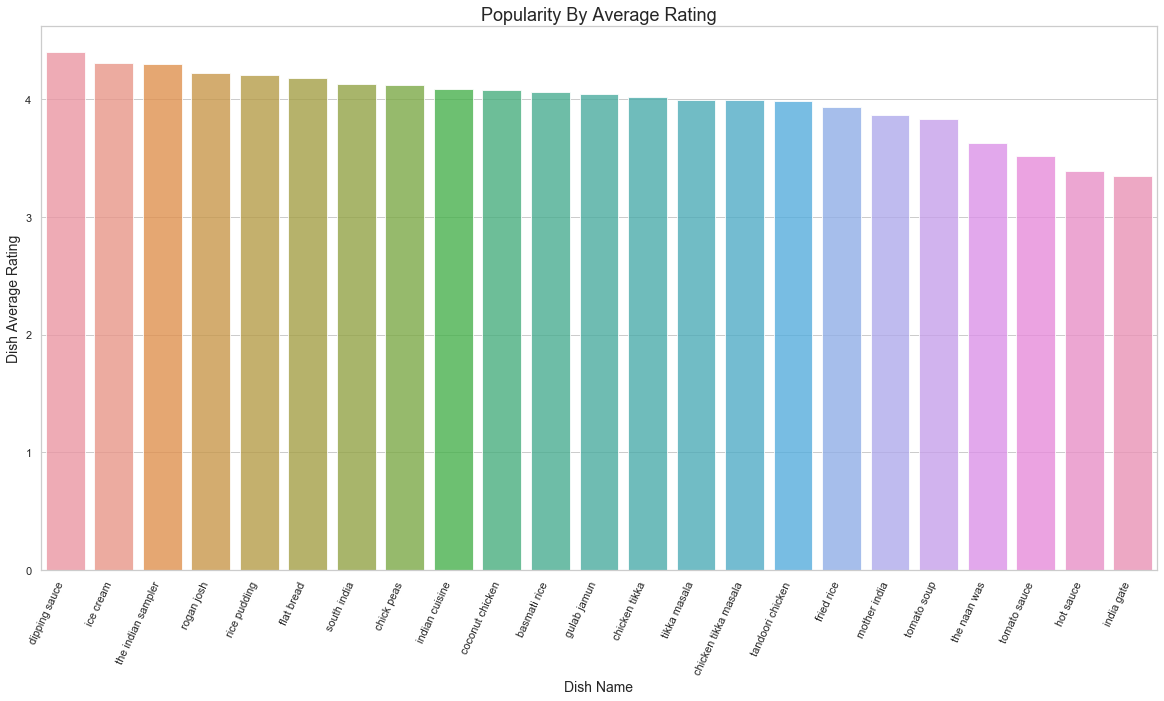

In [454]:
plt.figure(figsize=(20,10))
sns.barplot(x="Dish_Name", y="Average_Rating", data=dish_rating_df, alpha=0.8)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Popularity By Average Rating', fontsize=18)
plt.xlabel('Dish Name', fontsize=14)
plt.ylabel('Dish Average Rating', fontsize=14)
plt.show()

### 4D. Popularity By Sentiment

https://math.stackexchange.com/questions/377169/going-from-a-value-inside-1-1-to-a-value-in-another-range/377174#377174
```
Formula to transform range from [a,b] to [c,d], where we have [-1,1] to [0,10]
y = (x-a)(d-c)/(b-a) + c
5*(x+1)
```

In [467]:
%%time
# initialize dataframe
dish_sentiment_df = pd.DataFrame(columns=['Dish_Name', 'Total_Sentiment', "Review_Count"])
dish_sentiment_df['Dish_Name'] = dish_list
dish_sentiment_df['Total_Sentiment'] = [0]*len(dish_list)
dish_sentiment_df['Review_Count'] = [0]*len(dish_list)

for i, dish in enumerate(dish_list):
    for j, review in enumerate(reviews):
        if stars[j] == 3: # skip neutral reviews by stars
            continue
        review = review.replace("\t", " ")\
                      .replace("\n", "")\
                      .replace("\r", "")\
                      .lower().strip()
        if dish in review:
            toAnalyze = TextBlob(review)               # sentiment analysis part
            sent = toAnalyze.sentiment.polarity
            scaled_sent = 5*(sent+1)
            # Could use nltk VADER for sentiment analysis instead
            # analyzer = SentimentIntensityAnalyzer()
            # analyzer.polarity_scores(review)
            dish_sentiment_df.loc[i, 'Review_Count'] += 1 # used for average
            dish_sentiment_df.loc[i, 'Total_Sentiment'] += scaled_sent

        # compute average rating
dish_sentiment_df['Average_Sentiment'] = dish_sentiment_df['Total_Sentiment'] / dish_rating_df['Review_Count']

CPU times: user 7.72 s, sys: 27.3 ms, total: 7.75 s
Wall time: 7.74 s


In [469]:
# Sort and use # of reviews as tiebreaker if needed
dish_sentiment_df = dish_sentiment_df.sort_values(by=['Average_Sentiment', 'Review_Count'], axis=0, ascending=False)

In [470]:
dish_sentiment_df

,Dish_Name,Total_Sentiment,Review_Count,Average_Sentiment
18,the indian sampler,65.328618,10,6.532862
12,south india,1025.689363,162,6.331416
14,indian cuisine,1746.888854,278,6.283773
11,ice cream,443.137333,71,6.241371
4,rogan josh,391.553266,63,6.215131
0,chick peas,148.963267,24,6.206803
19,dipping sauce,246.152600,40,6.153815
8,rice pudding,841.087350,138,6.094836
17,india gate,121.894261,20,6.094713
10,fried rice,175.777196,29,6.061283


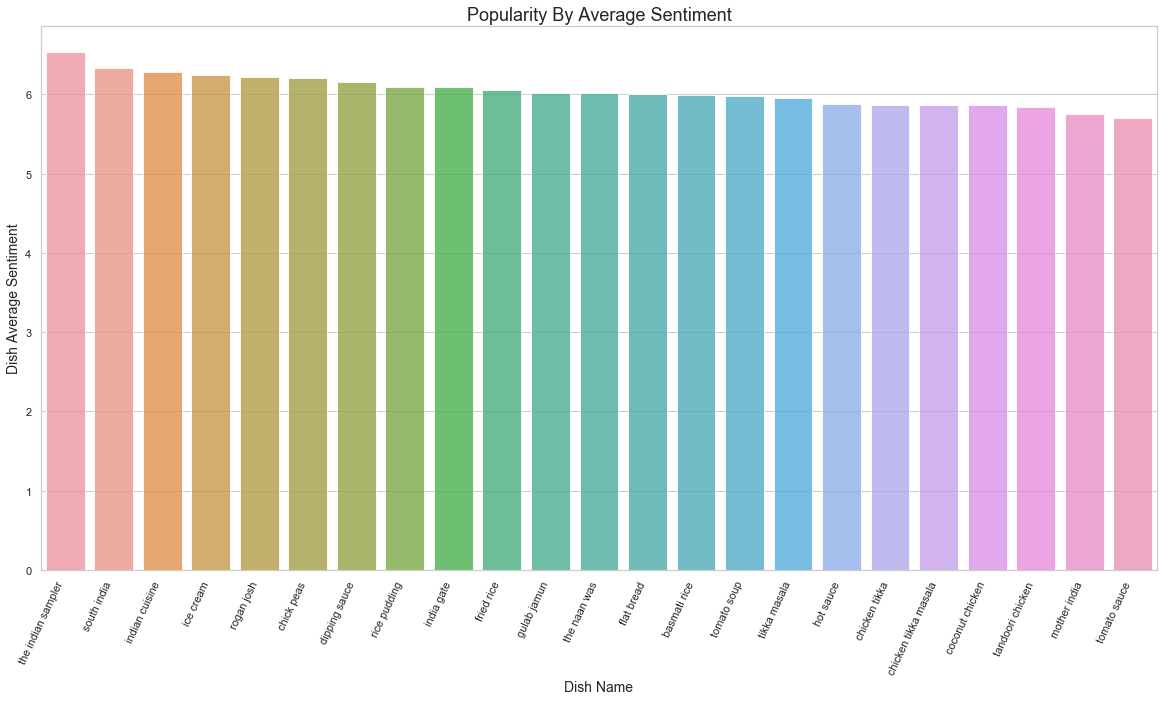

In [471]:
plt.figure(figsize=(20,10))
sns.barplot(x="Dish_Name", y="Average_Sentiment", data=dish_sentiment_df, alpha=0.8)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Popularity By Average Sentiment', fontsize=18)
plt.xlabel('Dish Name', fontsize=14)
plt.ylabel('Dish Average Sentiment', fontsize=14)
plt.show()

## Task 5: Restaurant Recommendation

In this task, your goal is to recommend good restaurants to those who would like to try one or more dishes in a cuisine. Given a particular dish, the general idea of solving this problem is to assess whether a restaurant is good for this dish based on whether the reviews of a candidate restaurant have included many positive (and very few negative) comments about the dish. You may choose a target dish or a set of target dishes from the list of "popular dishes" you generated from Task 4 or, otherwise, choose any dishes that have been mentioned many times in the review data (the more reviews you have for a dish, the more basis you will have for ranking restaurants).

You are required to create a visualization to show the ranking of the recommended restaurants. While a generic ranking of restaurants based on their overall ratings can be easily obtained, such a generic ranking is not as useful as one customized for a particular dish if one has decided to try this "particular dish." Thus, the ranking of restaurants you generated should be influenced somehow by the dish names you assumed to represent a diner's dining preference. The central question is thus how to design a dish-specific ranking algorithm for ranking restaurants. A simple approach easy to implement is to collect all the reviews mentioning a dish and compute the average ratings of these reviews for each restaurant so that a restaurant whose reviews containing the dish have the highest average rating would be ranked on the top. However, you are free to experiment with any parameters such as the rating of the restaurant, among other things.

Something to consider is to make your visualization general enough such that it could be used in a search engine or system and generate something useful for the users by recommending popular restaurants based on different dishes.

![](img/overview2.png)

*A visualization of the ranking of the restaurants in the Indian subset, based on the phrases mined.*

Note: My go-to di sh when I order from Indian restaurants is Chicken Tikka Masala - I know, I'm basic. So let's take the combination of dishes: *tikka masala, chicken tikka, chicken tikka masala* and determine how to rank the recommended restaurants.

In [473]:
selected_dishes = ['chicken tikka', 'chicken tikka masala', 'tikka masala']

### 5A. Recommendation By Average Rating
"A simple approach easy to implement is to collect all the reviews mentioning a dish and compute the average ratings of these reviews for each restaurant so that a restaurant whose reviews containing the dish have the highest average rating would be ranked on the top."

Here, we calculate the average ratings of the restaurants for our chosen dishes by dividing the total ratings by the number of reviews where at least one of 

In [563]:
unique_restaurants = list(set(rest_name))
rest_total_rating = OrderedDict(zip(unique_restaurants, [0]*len(unique_restaurants)))
rest_review_counter = OrderedDict(zip(unique_restaurants, [0]*len(unique_restaurants)))

for i, review in enumerate(reviews):
    review = review.replace("\t", " ").replace("\n", "").replace("\r", "").lower().strip()

#     # skip "neutral" reviews by stars
#     if stars[i] == 3:
#         continue
        
#     for dish in selected_dishes:
#         if dish in review:
#             rest_review_counter[rest_name[i]] += 1 # used for average
#             rest_total_rating[rest_name[i]] += stars[i]
    if (selected_dishes[0] in review) or (selected_dishes[1] in review) or (selected_dishes[2] in review):
        rest_review_counter[rest_name[i]] += 1 # used for average
        rest_total_rating[rest_name[i]] += stars[i]
    

In [564]:
rest_rating_df = pd.DataFrame(columns=['Restaurant_Name', 'Total_Rating', "Review_Count"])
rest_rating_df['Restaurant_Name'] = list(rest_total_rating.keys())
rest_rating_df['Total_Rating'] = list(rest_total_rating.values())
rest_rating_df['Review_Count'] = list(rest_review_counter.values())
rest_rating_df['Average_Rating'] = (rest_rating_df['Total_Rating'] + 1e-3)/ (rest_rating_df['Review_Count'] + 1e-3)

In [565]:
rest_rating_df

,Restaurant_Name,Total_Rating,Review_Count,Average_Rating
0,Flavor of India,23,5,4.599280
1,K2 Kebab House,0,0,1.000000
2,Tanjore,4,1,3.997003
3,Hurry 4 Curry,8,2,3.998501
4,Himalaya Tandoori Restaurant,0,0,1.000000
5,Kismot,5,1,4.996004
6,Le Passepartout,0,0,1.000000
7,Abida,0,0,1.000000
8,Bombay Bicycle Club,0,0,1.000000
9,Mithas,0,0,1.000000


In [566]:
# sort restaurants by average rating and use # of reviews as tiebreaker if needed
# drop restaurants with fewer than a predetermined minimum threshold of reviews
# select the top 10 (as Yelp often displays the results)
rest_rating_df = rest_rating_df.sort_values(by=['Average_Rating', 'Review_Count'], axis=0, ascending=False)\
                               .reset_index(drop=True)
display(rest_rating_df.head(25))
top10 = rest_rating_df[rest_rating_df['Review_Count'] >= 5].head(10)
top10

,Restaurant_Name,Total_Rating,Review_Count,Average_Rating
0,Mother India's Cafe,15,3,4.998667
1,Noor Indian Takeaway,10,2,4.998001
2,The Cholas,10,2,4.998001
3,Haweli Indian Grill & Bar,10,2,4.998001
4,Kismot,5,1,4.996004
5,Kebabish Original,5,1,4.996004
6,Haveli Restaurant,5,1,4.996004
7,10-to-10 In Delhi,5,1,4.996004
8,Aromas at Island Restaurant,5,1,4.996004
9,Pak Afghan Halal Restaurant & Catering,5,1,4.996004


,Restaurant_Name,Total_Rating,Review_Count,Average_Rating
11,Kebab Mahal,33,7,4.713755
14,Flavor of India,23,5,4.599280
15,Mount Everest India's Cuisine,181,40,4.524912
17,Star of India,66,15,4.399773
18,OM Restaurant,44,10,4.399660
19,India Garden,26,6,4.332778
20,Delhi Indian Cuisine,26,6,4.332778
22,Dhaba Indian Bistro,60,14,4.285480
23,Swad,30,7,4.285245
24,Maharaja Restaurant,47,11,4.272430


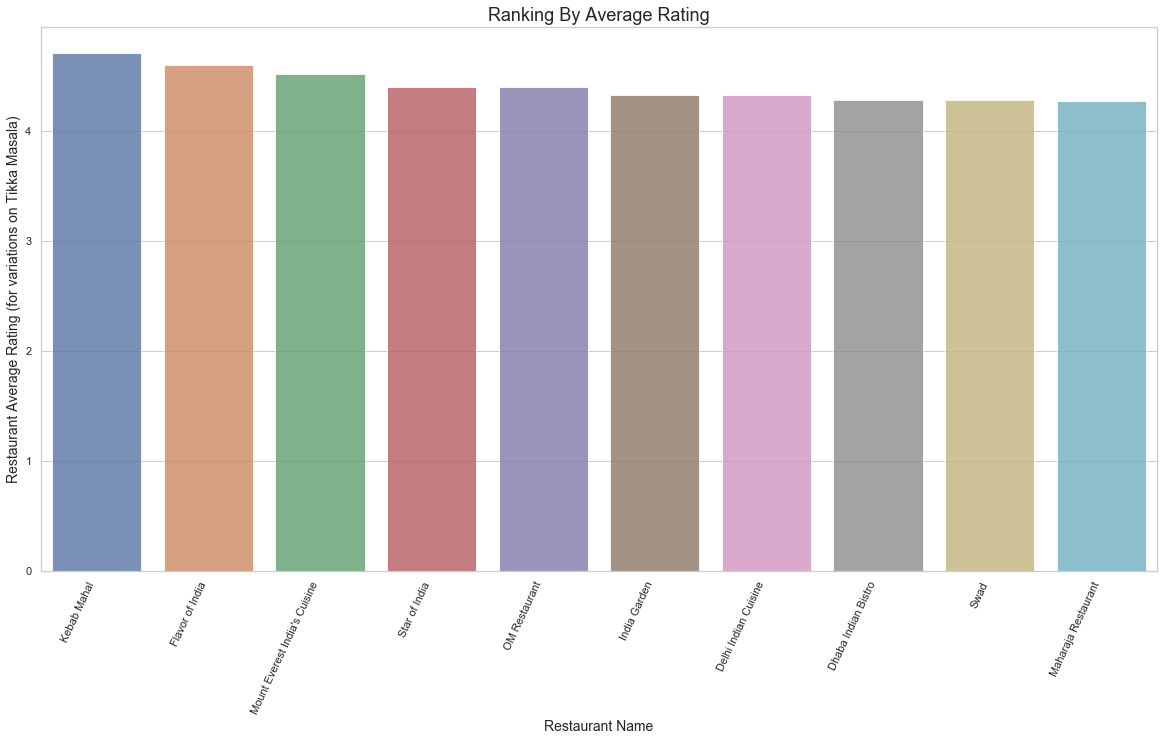

In [567]:
plt.figure(figsize=(20,10))
sns.barplot(x="Restaurant_Name", y="Average_Rating", data=top10, alpha=0.8)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Ranking By Average Rating', fontsize=18)
plt.xlabel('Restaurant Name', fontsize=14)
plt.ylabel('Restaurant Average Rating (for variations on Tikka Masala)', fontsize=14)
plt.show()

### 5B. Popularity By Average Sentiment
* skip 

In [573]:
unique_restaurants = list(set(rest_name))
rest_total_sentiment = OrderedDict(zip(unique_restaurants, [0]*len(unique_restaurants)))
rest_review_counter = OrderedDict(zip(unique_restaurants, [0]*len(unique_restaurants)))

for i, review in enumerate(reviews):
    review = review.replace("\t", " ").replace("\n", "").replace("\r", "").lower().strip()
    # skip "neutral" reviews by stars
    if stars[i] == 3:
        continue
    if (selected_dishes[0] in review) or (selected_dishes[1] in review) or (selected_dishes[2] in review):
        toAnalyze = TextBlob(review)               # sentiment analysis part
        sent = toAnalyze.sentiment.polarity
        scaled_sent = 5*(sent+1)
        rest_review_counter[rest_name[i]] += 1 # used for average
        rest_total_sentiment[rest_name[i]] += scaled_sent
    

In [574]:
rest_sentiment_df = pd.DataFrame(columns=['Restaurant_Name', 'Total_Sentiment', "Review_Count"])
rest_sentiment_df['Restaurant_Name'] = list(rest_total_sentiment.keys())
rest_sentiment_df['Total_Sentiment'] = list(rest_total_sentiment.values())
rest_sentiment_df['Review_Count'] = list(rest_review_counter.values())
rest_sentiment_df['Average_Sentiment'] = (rest_sentiment_df['Total_Sentiment'] + 1e-3)/ (rest_sentiment_df['Review_Count'] + 1e-3)

In [575]:
# sort restaurants by average sentiment and use # of reviews as tiebreaker if needed
# drop restaurants with fewer than a predetermined minimum threshold of reviews
# select the top 10 (as Yelp often displays the results)
rest_sentiment_df = rest_sentiment_df.sort_values(by=['Average_Sentiment', 'Review_Count'], axis=0, ascending=False)\
                                     .reset_index(drop=True)
display(rest_sentiment_df.head(25))
top10 = rest_sentiment_df[rest_sentiment_df['Review_Count'] >= 5].head(10)
top10

,Restaurant_Name,Total_Sentiment,Review_Count,Average_Sentiment
0,Haveli Restaurant,7.355492,1,7.349143
1,Curry Garden,21.257630,3,7.083849
2,Swad,34.477845,5,6.894390
3,Aromas at Island Restaurant,6.875000,1,6.869131
4,10-to-10 In Delhi,6.862500,1,6.856643
5,Kebab Mahal,47.067544,7,6.723117
6,Haweli Indian Grill & Bar,13.348670,2,6.671499
7,Aachi Southindian Kitchen,6.660494,1,6.654839
8,India Garden,32.851655,5,6.569217
9,Indus Village,19.236248,3,6.410279


,Restaurant_Name,Total_Sentiment,Review_Count,Average_Sentiment
2,Swad,34.477845,5,6.894390
5,Kebab Mahal,47.067544,7,6.723117
8,India Garden,32.851655,5,6.569217
14,Maharaja Restaurant E Pt Plaza,31.364668,5,6.271879
15,Copper Kettle,43.813030,7,6.258253
18,Taj Palace,198.983718,32,6.218078
19,Tandoori Times 3 Indian Bistro,74.617617,12,6.217700
20,Samosa Factory,111.179494,18,6.176351
21,OM Restaurant,55.575237,9,6.174451
22,Delhi Indian Cuisine,36.995961,6,6.165133


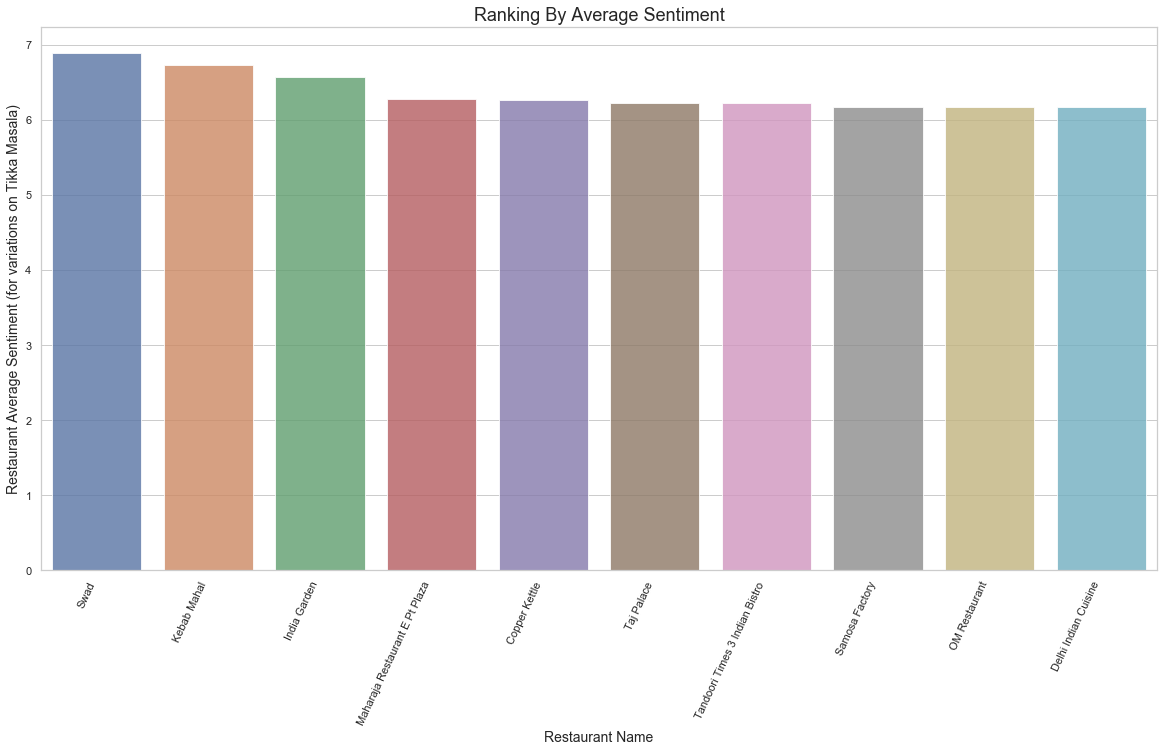

In [576]:
plt.figure(figsize=(20,10))
sns.barplot(x="Restaurant_Name", y="Average_Sentiment", data=top10, alpha=0.8)
plt.xticks(rotation=65, horizontalalignment='right')
plt.title('Ranking By Average Sentiment', fontsize=18)
plt.xlabel('Restaurant Name', fontsize=14)
plt.ylabel('Restaurant Average Sentiment (for variations on Tikka Masala)', fontsize=14)
plt.show()